<p>Goal - show examples of cross-validation for model selection and bootstrapping for prediction error estimation.
</p>

In [2]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn import linear_model
import os
os.chdir("C:/Users/kevin/Documents/GitHub/DS_course/ipython/")
import course_utils as bd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import imp
imp.reload(bd)

#Load data and downsample for a 50/50 split, then split into a train/test
f = 'C:/Users/kevin/Documents/GitHub/DS_course/datasets/ads_dataset_cut.txt'

train_split = 0.8
tdat = pd.read_csv(f, header = 0,sep = '\t')
moddat = bd.downSample(tdat, 'y_buy', 4)

#We know the dataset is sorted so we can just split by index
train = moddat[:int(np.floor(moddat.shape[0]*train_split))]
test = moddat[int(np.floor(moddat.shape[0]*train_split)):]



<p>Let's say we want to build a classifier that does ranking based on the probability of the label being 1. We can use Logistic Regression with AUC as our validation metric. We need to choose a regularization weight, but because we have limited data, we can do this via cross-validation.<br><br>

The following function performs the cross-validation for various levels of C

</p>

In [16]:
from sklearn.cross_validation import *

def xValAUC(tr, lab, k, cs):
    '''
    Perform k-fold cross validation on logistic regression, varies C,
    returns a dictionary where key=c,value=[auc-c1, auc-c2, ...auc-ck].
    '''
    cv = KFold(n = tr.shape[0], n_folds = k)
    aucs = {}

    for train_index, test_index in cv:
        tr_f = tr.iloc[train_index]
        va_f = tr.iloc[test_index]
    
        for c in cs:
            logreg = linear_model.LogisticRegression(C = c)
            logreg.fit(tr_f.drop(lab, 1),tr_f[lab])
            met = roc_auc_score(va_f[lab], logreg.predict_proba(va_f.drop(lab,1))[:,1])

            if c in aucs:
                aucs[c].append(met)
            else:
                aucs[c] = [met]
    
    return aucs

    

<p>Now we can run our experiment</p>

In [17]:
xval_dict = {'e':[], 'mu':[], 'sig':[]}
k = 10
auc_cv = xValAUC(train, 'y_buy', k, [10**i for i in range(-20,20)])
for i in range(-20,20):
    xval_dict['e'].append(i)
    xval_dict['mu'].append(np.array(auc_cv[10**i]).mean())
    xval_dict['sig'].append(np.sqrt(np.array(auc_cv[10**i]).var()))
    
    

<p>We can now load the results from above into a dataframe and begin to analyze

</p>

In [18]:
import numpy as np
res = pd.DataFrame(xval_dict)

#Get the confidence intervals
res['low'] = res['mu'] - 1.96*res['sig']/np.sqrt(10)
res['up'] = res['mu'] + 1.96*res['sig']/np.sqrt(10)

<p>Now let's plot the results to get a sense of how AUC varies with regularization strength. We'll also plot the lower and upper 95% confidence bands to get a sense of the variance.
</p>

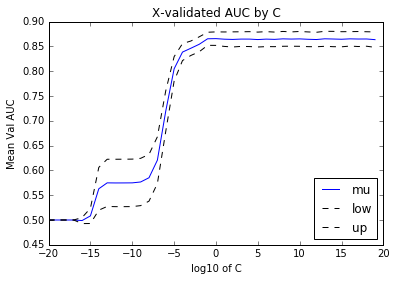

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(res['e'], res['mu'])
plt.plot(res['e'], res['low'], 'k--')
plt.plot(res['e'], res['up'], 'k--')

plt.legend(loc = 4)
ax.set_xlabel('log10 of C')
ax.set_ylabel('Mean Val AUC')
plt.title('X-validated AUC by C')


<p>We see that AUC is definitely affected by the choice of regularization strength (here we seem to do better with less regularization, probably due to very strong signal-to-noise in the data). But its hard to see what is best in the range $1$ to $10^{30}$. We can zoom in to see this better.

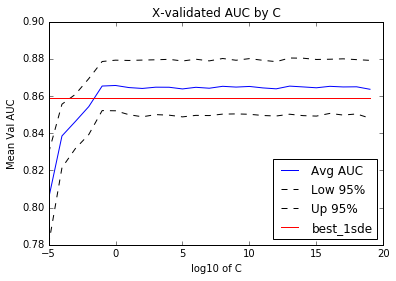

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

res2 = res[(res['e']>-6)]

best = res2['mu'].max()
best_1sde = best - res2['sig'][(res2['mu']==best)]/np.sqrt(10)

plt.plot(res2['e'], res2['mu'], label='Avg AUC')
plt.plot(res2['e'], res2['low'], 'k--', label='Low 95%')
plt.plot(res2['e'], res2['up'], 'k--', label='Up 95%')
plt.plot(res2['e'], best_1sde.values[0]*np.ones(res2.shape[0]), 'r', label='best_1sde')

plt.legend(loc=4)
ax.set_xlabel('log10 of C')
ax.set_ylabel('Mean Val AUC')
plt.title('X-validated AUC by C')

e_max = res2['e'][(res2['mu']==best)].values[0]
e_1sde = res2['e'][(res2['mu']>=best_1sde.values[0])].values.min()


<p>So now we have 2 ways to select our regularization:
<ul>
    <li>Choose C with $max(AUC_{xval})$</li>
    <li>Choose min(C) where $AUC_{xval}^C>max(AUC_{xval})-stderr(max(AUC_{xval})$</li>
</ul><br>
This latter decision criteria is more conservative and accounts for the fact that we have variance in our cross-validated estimates of AUC. We argue that any $C$ where $AUC_{xval}^C>max(AUC_{xval})-stderr(max(AUC_{xval})$ is statistically equivalent to the max. Therefore we take the most conservative, least complex model option.<br><br>

Now that we have selected a model, let's retrain on the full training set and evaluate on the test. We'll bootstrap the testing estimation so we can get a sense of the variance.
</p>

In [21]:
def testAUCBoot(test, nruns, model, lab):
    '''
    Samples with replacement, runs multiple eval attempts
    returns all bootstrapped results
    '''
    auc_res = []; oops = 0
    for i in range(nruns):
        test_samp = test.iloc[np.random.randint(0, len(test), size=len(test))]
        try:
            auc_res.append(roc_auc_score(test_samp[lab], model.predict_proba(test_samp.drop(lab,1))[:,1]))
        except:
            oops += 1
    return auc_res

In [22]:
lab = 'y_buy'
logreg_max = linear_model.LogisticRegression(C=10**e_max)
logreg_max.fit(train.drop(lab,1),train[lab])
auc_max = testAUCBoot(test, 100, logreg_max, lab)

logreg_1sde = linear_model.LogisticRegression(C=10**e_1sde)
logreg_1sde.fit(train.drop(lab,1),train[lab])
auc_1sde = testAUCBoot(test, 1000, logreg_1sde, lab)

<p>Now let's look at the distribution of AUC across the bootstrapped samples. Even though we can't use the test data for model selection, we can at least look at the test results for models built with the 2 selection criteria discussed above.

</p>


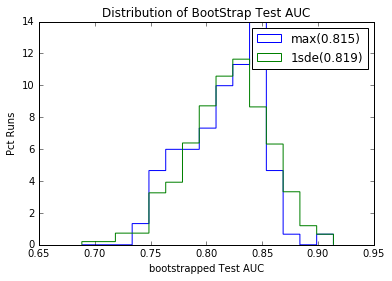

In [24]:
r = [min(min(auc_max), min(auc_1sde)),max(max(auc_max), max(auc_1sde))]
b = 15
fig = plt.figure()
frame = plt.gca()
ax = fig.add_subplot(111)
h1 = plt.hist(auc_max, range=r, bins=b, normed=True, histtype='step',stacked=True,label='max({})'.format(np.round(np.mean(auc_max),3)))
h2 = plt.hist(auc_1sde,range=r, bins=b, normed=True, histtype='step',stacked=True,label='1sde({})'.format(np.round(np.mean(auc_1sde),3)))
plt.legend()

ax.set_xlabel('bootstrapped Test AUC')
ax.set_ylabel('Pct Runs')
plt.title('Distribution of BootStrap Test AUC')
